# Dataset Size Study on Synthetic Dataset

The purpose of this notebook is to 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [24]:
from autoplan.trainer import ClassifierTrainer, option_combinations
from autoplan.dataset import PrelabeledDataset, build_synthetic_dataset, TrainVal
from autoplan.generator import ProgramGenerator
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import TokenType, PyretTokenizer, OCamlTokenizer
from scripts.rainfall_ingest import ingest_dataset

from grammars.rainfall.ocaml import Program
from grammars.rainfall.labels import GeneralRainfallLabels

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
# import seaborn as sns

# device = torch.device('cpu')
device = torch.device('cuda:2')
REPO_DIR = os.path.expanduser('~/autoplan')
path = os.path.expanduser('~/autoplan/data/pickle')

In [4]:
dataset_name = 'T1'
student_dataset = ingest_dataset(dataset_name)

Skipped 16 programs


In [5]:
sample_size = [
    ('N', [100, 300, 500, 1000, 5000])
]

# k is the number of datasets generated for each sample size
k = 5

datasets = [
    (opts, build_synthetic_dataset(
                GeneralRainfallLabels,
                tokenizer=OCamlTokenizer(),
                generator=ProgramGenerator(grammar=Program(), adaptive=True),
                vocab_index=student_dataset.vocab_index,
                **opts))
    for opts in option_combinations(sample_size)
        for i in range(k)
]

Generating programs...
Generated 93 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 95 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 93 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 90 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 93 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 233 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 253 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 229 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 251 unique programs.
Tokenizing programs...
Building dataset metadata...
Generating programs...
Generated 236 unique program

In [21]:
path = os.path.expanduser('~/autoplan/data/pickle_data/synthetic/data_size_synthetic')
pickle.dump(datasets, open(path, 'wb'))

In [25]:
model_options = [
    ('dataset', datasets),
    ('model', [nn.GRU, nn.LSTM]),
    ('hidden_size', [512]),
    ('embedding_size', [512]),
]

all_evals = [
    (opts, ClassifierTrainer.crossval(opts['dataset'][1], epochs=100, device=device,
                                      split=TrainVal(opts['dataset'][1], student_dataset), 
                                      model_opts={k: v for k, v in opts.items() if k != 'dataset'}))
    for opts in tqdm(option_combinations(model_options))
]

In [26]:
sorted([{
    'params': k, 
    'accuracy': np.mean(v['accuracy'])
} for k, v in all_evals], key=lambda t: -t['accuracy'])

[{'params': {'embedding_size': 512,
   'hidden_size': 512,
   'model': torch.nn.modules.rnn.GRU,
   'dataset': ({'N': 5000},
    SyntheticDataset(dataset=<autoplan.dataset.ProgramDataset object at 0x7f72cf1affd0>, vocab_size=63, vocab_index={('LET', ''): 0, ('REC', ''): 1, 'LIDENT': 2, ('LPAREN', ''): 3, ('COLON', ''): 4, ('RPAREN', ''): 5, ('EQUAL', ''): 6, ('MATCH', ''): 7, ('COMMA', ''): 8, ('WITH', ''): 9, ('BAR', ''): 10, ('LBRACKET', ''): 11, ('RBRACKET', ''): 12, ('FLOAT', '0.'): 13, ('MINUSGREATER', ''): 14, 'STRING': 15, ('MINUS', ''): 16, ('FLOAT', '999.'): 17, ('COLONCOLON', ''): 18, ('UNDERSCORE', ''): 19, ('IF', ''): 20, ('INFIXOP0', '>='): 21, ('THEN', ''): 22, ('PLUSDOT', ''): 23, ('FLOAT', '1.'): 24, ('ELSE', ''): 25, ('STAR', ''): 26, ('IN', ''): 27, ('INFIXOP3', '/.'): 28, ('INT', '0'): 29, ('INFIXOP3', '/'): 30, ('INT', '999'): 31, ('GREATER', ''): 32, ('INT', '1'): 33, ('PLUS', ''): 34, ('LESS', ''): 35, ('WHEN', ''): 36, ('INFIXOP0', '!='): 37, ('SEMI', ''): 38, ('

[{'embedding_size': 512, 'hidden_size': 512, 'model': 'GRU', 'N': 100, 'avg_accuracy': 0.76}]
[{'embedding_size': 512, 'hidden_size': 512, 'model': 'GRU', 'N': 100, 'avg_accuracy': 0.76}, {'embedding_size': 512, 'hidden_size': 512, 'model': 'LSTM', 'N': 100, 'avg_accuracy': 0.8}]
[{'embedding_size': 512, 'hidden_size': 512, 'model': 'GRU', 'N': 100, 'avg_accuracy': 0.76}, {'embedding_size': 512, 'hidden_size': 512, 'model': 'LSTM', 'N': 100, 'avg_accuracy': 0.8}, {'embedding_size': 512, 'hidden_size': 512, 'model': 'GRU', 'N': 300, 'avg_accuracy': 0.7822222222222222}]
[{'embedding_size': 512, 'hidden_size': 512, 'model': 'GRU', 'N': 100, 'avg_accuracy': 0.76}, {'embedding_size': 512, 'hidden_size': 512, 'model': 'LSTM', 'N': 100, 'avg_accuracy': 0.8}, {'embedding_size': 512, 'hidden_size': 512, 'model': 'GRU', 'N': 300, 'avg_accuracy': 0.7822222222222222}, {'embedding_size': 512, 'hidden_size': 512, 'model': 'LSTM', 'N': 300, 'avg_accuracy': 0.8399999999999999}]
[{'embedding_size': 512

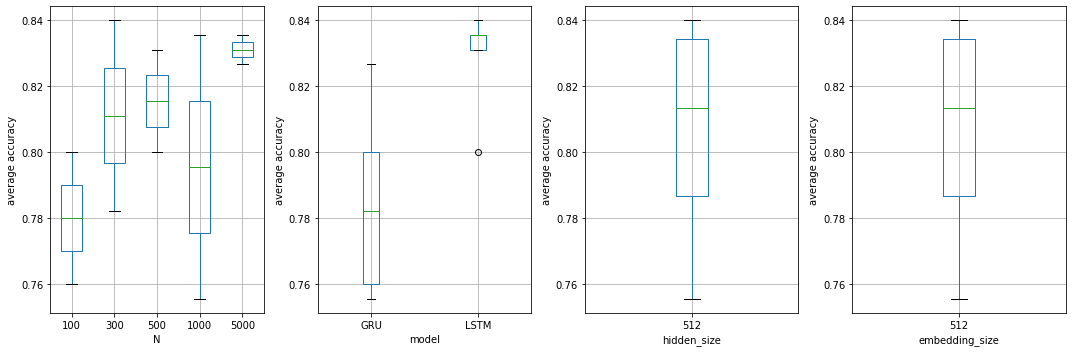

In [27]:
# All combinations of the options we are testing on
sample_specs = [
    ('N', [100, 300, 500, 1000, 5000]),
    ('model', [nn.GRU, nn.LSTM]),
    ('hidden_size', [512]),
    ('embedding_size', [512]),
]

# A function that returns a list of all samples that can be generated given the `sample_specs`,
# and the average of the maximum accuracy obtained after training and evaluating each sample. 
def get_samples_data(sample_specs):
    samples = []
    for sample in option_combinations(sample_specs):
        accuracies = []
    
        for i in range(len(all_evals)):
            if (all_evals[i][0]['dataset'][0]['N'] == sample['N'] and \
                all_evals[i][0]['embedding_size'] == sample['embedding_size'] and \
                all_evals[i][0]['hidden_size'] == sample['hidden_size'] and \
                all_evals[i][0]['model'] == sample['model']):
                    accuracies.append(all_evals[i][1]['accuracy'])
        
        avg_accuracy = np.mean(accuracies)
        sample.update({'avg_accuracy': avg_accuracy})
        sample.update({'model': str(sample['model'].__name__)})
        samples.append(sample)
        print(samples)
    return samples

# We extract the data for each sample and plot it for analysis
samples = get_samples_data(sample_specs)
df = pd.DataFrame.from_dict(samples)
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for ax, (k, _) in zip(axes, sample_specs):
    df.boxplot(column=['avg_accuracy'], by=k, ax=ax)
    ax.set_title('')
    ax.set_ylabel('average accuracy')
    
plt.suptitle('')
plt.tight_layout()